In [ ]:
from pyemma.msm import MaximumLikelihoodMSM, BayesianMSM, MaximumLikelihoodHMSM, its
from bhmm import lag_observations
import pyemma.plots as mplt
import pyemma.coordinates as coor
from msmbuilder.cluster import NDGrid
from sklearn.pipeline import Pipeline
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import entropy
import pandas as pd

In [ ]:
taus = [5, 8, 37, 94, 484]
results = [pd.read_hdf('h_state_selection.h5', key='tau{}'.format(x)) for x in taus]

In [ ]:
df = pd.concat(results)

## Correct number of observations

Can't decide what is correct here! 

In [ ]:
# df.head()

In [ ]:
# df['n_obs_2'] = df['n_obs'] - df['tau']*99
# df['ll'] = (df['dofs'] -0.5*df['aic'])

In [ ]:
# df.head()

In [ ]:
# df['bic'] = np.log(df['n_obs_2'])*df['dofs'] - 2*df['ll']

In [ ]:
# df.head()

In [ ]:
# df.tail()

In [ ]:
# df['icl'] = df['bic'] + 2*df['entropy']*(df['n_obs_2']/df['n_obs'])

In [ ]:
## Normalize scores

In [4]:
df.loc[:, 'aic'] /= df.loc[:, 'n_obs']
df.loc[:, 'bic'] /= df.loc[:, 'n_obs']
df.loc[:, 'icl'] /= df.loc[:, 'n_obs']

## Select data for chart dataframe

In [5]:
crit = df.loc[:, ['aic', 'bic', 'icl', 'k', 'tau']]

In [6]:
crit_melt = pd.melt(frame=crit, id_vars=['k', 'tau'], value_name='score', var_name='criterion')
crit_melt.loc[:, 'score'] *= (-0.5)



In [7]:
crit_melt.loc[:, 'criterion'] = crit_melt.loc[:, 'criterion'].str.upper()

In [8]:
min_scores = crit_melt.groupby(['tau', 'criterion'])['score'].transform('max')
idx = crit_melt['score'] == min_scores
best = crit_melt.loc[idx, :]
best

,k,tau,criterion,score
7,9,5,AIC,-3.636552
14,8,8,AIC,-3.765100
23,9,37,AIC,-4.187410
29,7,94,AIC,-4.455589
39,9,484,AIC,-4.844606
47,9,5,BIC,-3.691031
54,8,8,BIC,-3.813403
59,5,37,BIC,-4.228180
66,4,94,BIC,-4.482038
73,3,484,BIC,-4.872546


In [9]:
criteria = crit_melt['criterion'].unique()


In [10]:
best_k = pd.read_hdf('best_k.h5')
best_k.loc[:, 'n_resolvable'] += 1 # Make a correction! 

In [11]:
best_k

,best_k,n_resolvable,tau
0,8,8,5
1,4,6,8
2,4,4,37
3,3,3,94
4,2,2,484


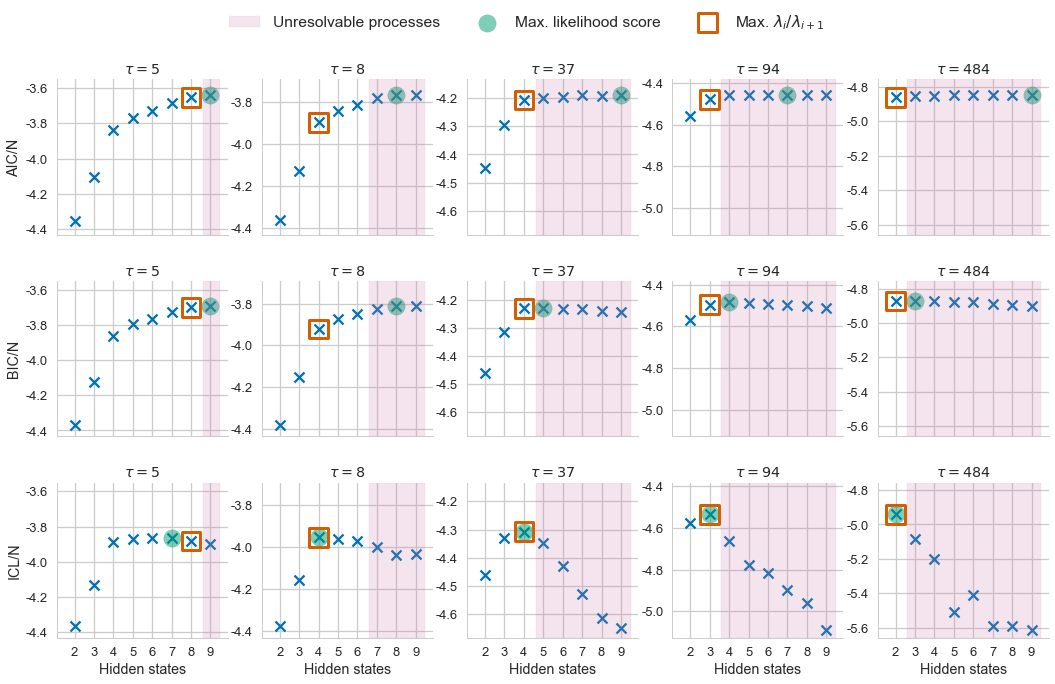

In [18]:
from matplotlib.markers import MarkerStyle
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
import matplotlib.ticker as ticker

with sns.plotting_context('talk', font_scale=1):
    sns.set_style('whitegrid')

    # parameters for axes
    cols = sns.color_palette('colorblind', 4)
    max_k = crit_melt['k'].max()
    delx = 0.1
    
    
    g = sns.FacetGrid(data=crit_melt, row='criterion',col='tau', row_order=criteria, col_order=taus, 
                      sharey='col')
    g = g.map(plt.scatter, 'k', 'score', s=100, marker='x', color=cols[0])
    
    for ax in g.axes.flatten():
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:4.1f}'))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
    
    g = g.set_axis_labels('Hidden states')
    for i, ax in enumerate(g._left_axes):
        ax.set_ylabel('{}/N'.format(criteria[i]))
        
    g = g.set_titles(r'$\tau={col_name}$')
    
    for (row_i, col_j, hue_k), data_ijk in g.facet_data():
        ax = g.facet_axis(row_i, col_j)
        
        # Best likelihood criteria
        idx = (best['criterion']==criteria[row_i]) & (best['tau'] == taus[col_j])
        k = best.loc[idx, 'k']
        y = best.loc[idx, 'score']
        
        leg1 = ax.scatter(k, y, marker='o', s=300, alpha=0.5, linewidths=None, color=cols[1], 
                   label='Max. likelihood score')
        
        # largest eigenvalue gap
        jdx = (best_k['tau'] == taus[col_j])
        k = best_k.loc[jdx, 'best_k'].values[0]
        kdx = (crit_melt['tau']==taus[col_j]) & (crit_melt['k']==k) & (crit_melt['criterion']==criteria[row_i])
        y = crit_melt.loc[kdx, 'score']
        
        leg2 = ax.scatter(k, y, marker='s', s=350, facecolors='none', linewidths=3, color=cols[2], 
                  label='Max. $\lambda_i/\lambda_{i+1}$')
    
        # Shade out unresolvable 
        
        trans = mtransforms.blended_transform_factory(
            ax.transData, ax.transAxes)
        unresolve = best_k.loc[jdx, 'n_resolvable'].values[0] + 0.5 + delx
        width = -unresolve+(max_k+0.5)
        rect = patches.Rectangle((unresolve,0), width=width, height=1,
                                 transform=trans, color=cols[3],
                                 alpha=0.2, label='Unresolvable processes')
        leg3 = ax.add_patch(rect)
    
    g.axes.flatten()[-1].legend(bbox_to_anchor=(0.5, 1.0), 
                                bbox_transform=plt.gcf().transFigure, loc='lower center', 
                               labelspacing=1, fontsize='medium', ncol=3)
    g = g.fig.subplots_adjust(wspace=.2, hspace=.3)
    plt.savefig('Figures/h_state_selection_quad_well.pdf', dpi=300, bbox_inches='tight')